# Basic Text Classification with Naive Bayes
***
In the mini-project, you'll learn the basics of text analysis using a subset of movie reviews from the rotten tomatoes database. You'll also use a fundamental technique in Bayesian inference, called Naive Bayes. This mini-project is based on [Lab 10 of Harvard's CS109](https://github.com/cs109/2015lab10) class.  Please free to go to the original lab for additional exercises and solutions.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from six.moves import range

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

In [2]:
# import my tools
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from IPython.display import display_html

In [3]:
# import more plotting tools
from IPython.core.pylabtools import figsize
# set grid size
figsize(12, 4)

Use "mp.colors(<index>)" as color attribute for Seaborn plots.
This is your color palette...


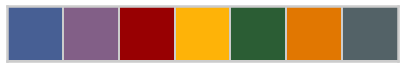

In [4]:
# import custom palette
import my_palette as mp

# Table of Contents

* [Rotten Tomatoes Dataset](#Rotten-Tomatoes-Dataset)
    * [Explore](#Explore)
* [The Vector Space Model and a Search Engine](#The-Vector-Space-Model-and-a-Search-Engine)
    * [In Code](#In-Code)
* [Naive Bayes](#Naive-Bayes)
    * [Multinomial Naive Bayes and Other Likelihood Functions](#Multinomial-Naive-Bayes-and-Other-Likelihood-Functions)
    * [Picking Hyperparameters for Naive Bayes and Text Maintenance](#Picking-Hyperparameters-for-Naive-Bayes-and-Text-Maintenance)
* [Interpretation](#Interpretation)


## Rotten Tomatoes Dataset

In [5]:
critics = pd.read_csv('./critics.csv')
#let's drop rows with missing quotes
critics = critics[~critics.quote.isnull()]
critics.head()

,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,fresh,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,fresh,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,Jonathan Rosenbaum,fresh,114709,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story


In [6]:
# observe data
critics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15561 entries, 1 to 27616
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   critic       14792 non-null  object
 1   fresh        15561 non-null  object
 2   imdb         15561 non-null  int64 
 3   publication  15561 non-null  object
 4   quote        15561 non-null  object
 5   review_date  15561 non-null  object
 6   rtid         15561 non-null  int64 
 7   title        15561 non-null  object
dtypes: int64(2), object(6)
memory usage: 1.1+ MB


In [7]:
# count rows with missing critics
critics['critic'].isna().sum()

769

The critic column has missing data. These rows should be discarded if analyzing by critic.

In [8]:
# observe unique values in fresh column
critics['fresh'].value_counts()

fresh     9482
rotten    6052
none        27
Name: fresh, dtype: int64

The fresh column has missing data. These rows should be dropped if predicting freshness.

In [9]:
# observe the critics
critics['critic'].value_counts()

Roger Ebert           1132
James Berardinelli     804
Janet Maslin           515
Variety Staff          430
Jonathan Rosenbaum     412
                      ... 
Milo Miles               1
Leba Hertz               1
Athima Chansanchai       1
David Mermelstein        1
Simon Houpt              1
Name: critic, Length: 622, dtype: int64

In [10]:
# get percent of reviews from top two critics
np.sum(list(np.divide(critics['critic'].value_counts().to_list(), len(critics['critic'])))[0:2])

0.12441359809780864

Over 12% of the reviews are attributed to two critics. This data is unbalanced.

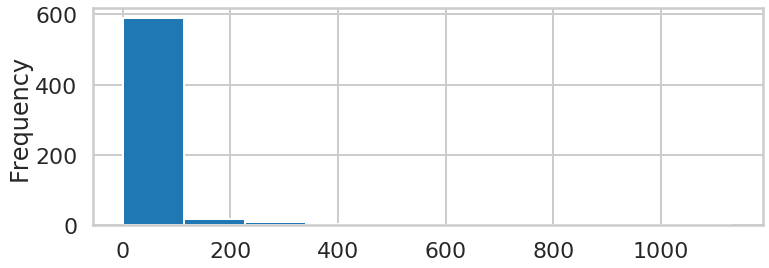

In [11]:
# quickly visually observe the unbalanced data
critics['critic'].value_counts().plot.hist();

### Explore

In [12]:
n_reviews = len(critics)
n_movies = critics.rtid.unique().size
n_critics = critics.critic.unique().size


print("Number of reviews: {:d}".format(n_reviews))
print("Number of critics: {:d}".format(n_critics))
print("Number of movies:  {:d}".format(n_movies))

Number of reviews: 15561
Number of critics: 623
Number of movies:  1921


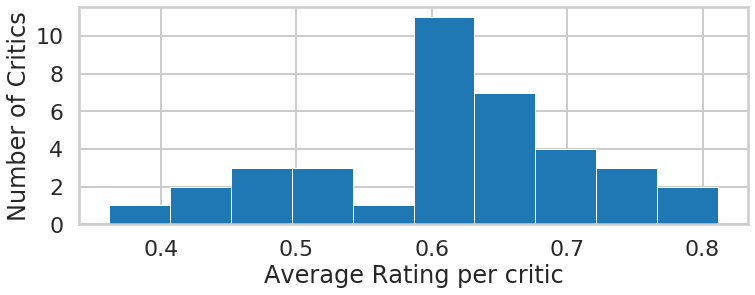

In [13]:
df = critics.copy()
df['fresh'] = df.fresh == 'fresh' # make fresh column boolean
grp = df.groupby('critic') # aggregate by critic
counts = grp.critic.count()  # number of reviews by each critic
means = grp.fresh.mean()     # average freshness for each critic

means[counts > 100].hist(bins=10, edgecolor='w', lw=1)
plt.xlabel("Average Rating per critic")
plt.ylabel("Number of Critics")
plt.yticks([0, 2, 4, 6, 8, 10]);

Before continuing, it should be noted that the label on the x axis is misleading.<br>
There are no ratings in this plot, only the averages of recommendations whether to see a movie or not to see a movie.

In [14]:
# observe number of critics with no favorable recommendations in full dataset
(means == 0).sum()

108

In [15]:
# observe number of critics with all favorable recommendations in full dataset
(means == 1).sum()

194

In [16]:
# observe percentage of critics in full dataset with no varience in their freshness ratings
(means == 0).append(means == 1).sum() / n_critics

0.48475120385232745

Almost half of these reviews come from critics who give all movies the same recommendation.

<div class="span5 alert alert-info">
<h3>Exercise Set I</h3>
<br/>
<b>Exercise:</b> Look at the histogram above. Tell a story about the average ratings per critic. What shape does the distribution look like? What is interesting about the distribution? What might explain these interesting things?
</div>

The histogram was constructed to exclude critics with a low number of recommendations.<br>
I will observe what choosing a threshold of 100 recommendations does to the data.

In [17]:
# get number of critics included in histogram
len(means[counts > 100])

37

The sample size is relatively small.

In [18]:
# get percentage of critics included in histogram
len(means[counts > 100]) / n_critics

0.0593900481540931

Plotting only those critics with more than 100 recommendations is like starting over with a new dataset.<br>
These critics account for just under 6% of the original set.

In [19]:
# determining negative skewness
means[counts > 100].mean() < means[counts > 100].median()

True

In [20]:
# get the range of average recommendations
means[counts > 100].min(), means[counts > 100].max()

(0.3620689655172414, 0.8114035087719298)

In [21]:
# get the mean and standard deviation of the distribution
means.mean(), np.std(means[counts > 100])

(0.5973196238943221, 0.10073968323719852)

The story of the average recommendations per critic is that established critics will recommend a movie more than not recommend a movie.<br>
This is observed by the left-skew of the distribution.<br>
The range strays about two standard deviations from the mean on either side, implying that established critics are not overly harsh or lenient.<br>
The distribution appears bimodal, but the small sample size begs us to use a unimodal shape if we were fitting a curve to it.

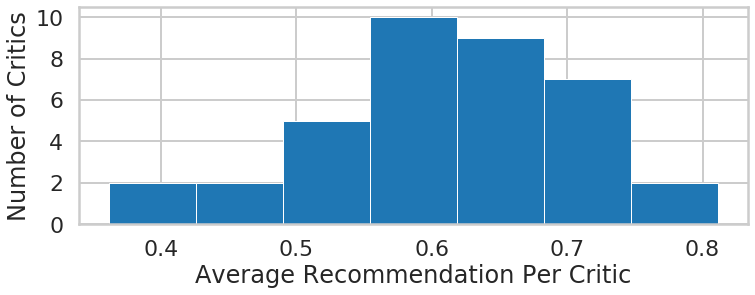

In [22]:
# plot critic distribution using larger bins

means[counts > 100].hist(bins=7, edgecolor='w', lw=1)
plt.xlabel("Average Recommendation Per Critic")
plt.ylabel("Number of Critics")
plt.yticks([0, 2, 4, 6, 8, 10]);

By changing the bin size, I am able to erase the bimodal shape of the distribution, making it appear closer to normal.<br>
This implies that the truth of the bimodality of the distribution needs further investigation.

Something intersting to note about the distribution is that established critics recommend seeing a movie more than they recommend not seeing a movie.<br>
The reason for this may be self preservation.<br>
If a movie is more likely to be a waste of time and/or money, then the potential viewer may want to find something else to do other than watch a movie.<br>
Then, they wouldn't need a movie critic.

## The Vector Space Model and a Search Engine

All the diagrams here are snipped from [*Introduction to Information Retrieval* by Manning et. al.]( http://nlp.stanford.edu/IR-book/) which is a great resource on text processing. For additional information on text mining and natural language processing, see [*Foundations of Statistical Natural Language Processing* by Manning and Schutze](http://nlp.stanford.edu/fsnlp/).

Also check out Python packages [`nltk`](http://www.nltk.org/), [`spaCy`](https://spacy.io/), [`pattern`](http://www.clips.ua.ac.be/pattern), and their associated resources. Also see [`word2vec`](https://en.wikipedia.org/wiki/Word2vec).

Let us define the vector derived from document $d$ by $\bar V(d)$. What does this mean? Each document is treated as a vector containing information about the words contained in it. Each vector has the same length and each entry "slot" in the vector contains some kind of data about the words that appear in the document such as presence/absence (1/0), count (an integer) or some other statistic. Each vector has the same length because each document shared the same vocabulary across the full collection of documents -- this collection is called a *corpus*.

To define the vocabulary, we take a union of all words we have seen in all documents. We then just associate an array index with them. So "hello" may be at index 5 and "world" at index 99.

Suppose we have the following corpus:

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree. The grapes seemed ready to burst with juice, and the Fox's mouth watered as he gazed longingly at them.`

Suppose we treat each sentence as a document $d$. The vocabulary (often called the *lexicon*) is the following:

$V = \left\{\right.$ `a, along, and, as, at, beautiful, branches, bunch, burst, day, fox, fox's, from, gazed, grapes, hanging, he, juice, longingly, mouth, of, one, ready, ripe, seemed, spied, the, them, to, trained, tree, vine, watered, with`$\left.\right\}$

Then the document

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree`

may be represented as the following sparse vector of word counts:

$$\bar V(d) = \left( 4,1,0,0,0,1,1,1,0,1,1,0,1,0,1,1,0,0,0,0,2,1,0,1,0,0,1,0,0,1,1,1,0,0 \right)$$

or more succinctly as

`[(0, 4), (1, 1), (5, 1), (6, 1), (7, 1), (9, 1), (10, 1), (12, 1), (14, 1), (15, 1), (20, 2), (21, 1), (23, 1),`
`(26, 1), (29,1), (30, 1), (31, 1)]`

along with a dictionary

``
{
    0: a, 1: along, 5: beautiful, 6: branches, 7: bunch, 9: day, 10: fox, 12: from, 14: grapes, 15: hanging, 19: mouth, 20: of, 21: one, 23: ripe, 24: seemed, 25: spied, 26: the, 29:trained, 30: tree, 31: vine, 
}
``

Then, a set of documents becomes, in the usual `sklearn` style, a sparse matrix with rows being sparse arrays representing documents and columns representing the features/words in the vocabulary.

Notice that this representation loses the relative ordering of the terms in the document. That is "cat ate rat" and "rat ate cat" are the same. Thus, this representation is also known as the Bag-Of-Words representation.

Here is another example, from the book quoted above, although the matrix is transposed here so that documents are columns:

![novel terms](terms.png)

Such a matrix is also catted a Term-Document Matrix. Here, the terms being indexed could be stemmed before indexing; for instance, `jealous` and `jealousy` after stemming are the same feature. One could also make use of other "Natural Language Processing" transformations in constructing the vocabulary. We could use Lemmatization, which reduces words to lemmas: work, working, worked would all reduce to work. We could remove "stopwords" from our vocabulary, such as common words like "the". We could look for particular parts of speech, such as adjectives. This is often done in Sentiment Analysis. And so on. It all depends on our application.

From the book:
>The standard way of quantifying the similarity between two documents $d_1$ and $d_2$  is to compute the cosine similarity of their vector representations $\bar V(d_1)$ and $\bar V(d_2)$:

$$S_{12} = \frac{\bar V(d_1) \cdot \bar V(d_2)}{|\bar V(d_1)| \times |\bar V(d_2)|}$$

![Vector Space Model](vsm.png)


>There is a far more compelling reason to represent documents as vectors: we can also view a query as a vector. Consider the query q = jealous gossip. This query turns into the unit vector $\bar V(q)$ = (0, 0.707, 0.707) on the three coordinates below. 

![novel terms](terms2.png)

>The key idea now: to assign to each document d a score equal to the dot product:

$$\bar V(q) \cdot \bar V(d)$$

Then we can use this simple Vector Model as a Search engine.

### In Code

In [23]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['Hop on pop', 'Hop off pop', 'Hop Hop hop']
print("Original text is\n{}".format('\n'.join(text)))

vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print("")
print("Transformed text vector is \n{}".format(x))

# `get_feature_names` tracks which word is associated with each column of the transformed x
print("")
print("Words for each feature:")
print(vectorizer.get_feature_names())

# Notice that the bag of words treatment doesn't preserve information about the *order* of words, 
# just their frequency

Original text is
Hop on pop
Hop off pop
Hop Hop hop

Transformed text vector is 
[[1 0 1 1]
 [1 1 0 1]
 [3 0 0 0]]

Words for each feature:
['hop', 'off', 'on', 'pop']


In [24]:
def make_xy(critics, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(critics.quote)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = (critics.fresh == 'fresh').values.astype(np.int)
    return X, y
X, y = make_xy(critics)

## Naive Bayes

From Bayes' Theorem, we have that

$$P(c \vert f) = \frac{P(c \cap f)}{P(f)}$$

where $c$ represents a *class* or category, and $f$ represents a feature vector, such as $\bar V(d)$ as above. **We are computing the probability that a document (or whatever we are classifying) belongs to category *c* given the features in the document.** $P(f)$ is really just a normalization constant, so the literature usually writes Bayes' Theorem in context of Naive Bayes as

$$P(c \vert f) \propto P(f \vert c) P(c) $$

$P(c)$ is called the *prior* and is simply the probability of seeing class $c$. But what is $P(f \vert c)$? This is the probability that we see feature set $f$ given that this document is actually in class $c$. This is called the *likelihood* and comes from the data. One of the major assumptions of the Naive Bayes model is that the features are *conditionally independent* given the class. While the presence of a particular discriminative word may uniquely identify the document as being part of class $c$ and thus violate general feature independence, conditional independence means that the presence of that term is independent of all the other words that appear *within that class*. This is a very important distinction. Recall that if two events are independent, then:

$$P(A \cap B) = P(A) \cdot P(B)$$

Thus, conditional independence implies

$$P(f \vert c)  = \prod_i P(f_i | c) $$

where $f_i$ is an individual feature (a word in this example).

To make a classification, we then choose the class $c$ such that $P(c \vert f)$ is maximal.

There is a small caveat when computing these probabilities. For [floating point underflow](http://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html) we change the product into a sum by going into log space. This is called the LogSumExp trick. So:

$$\log P(f \vert c)  = \sum_i \log P(f_i \vert c) $$

There is another caveat. What if we see a term that didn't exist in the training data? This means that $P(f_i \vert c) = 0$ for that term, and thus $P(f \vert c)  = \prod_i P(f_i | c) = 0$, which doesn't help us at all. Instead of using zeros, we add a small negligible value called $\alpha$ to each count. This is called Laplace Smoothing.

$$P(f_i \vert c) = \frac{N_{ic}+\alpha}{N_c + \alpha N_i}$$

where $N_{ic}$ is the number of times feature $i$ was seen in class $c$, $N_c$ is the number of times class $c$ was seen and $N_i$ is the number of times feature $i$ was seen globally. $\alpha$ is sometimes called a regularization parameter.

### Multinomial Naive Bayes and Other Likelihood Functions

Since we are modeling word counts, we are using variation of Naive Bayes called Multinomial Naive Bayes. This is because the likelihood function actually takes the form of the multinomial distribution.

$$P(f \vert c) = \frac{\left( \sum_i f_i \right)!}{\prod_i f_i!} \prod_{f_i} P(f_i \vert c)^{f_i} \propto \prod_{i} P(f_i \vert c)$$

where the nasty term out front is absorbed as a normalization constant such that probabilities sum to 1.

There are many other variations of Naive Bayes, all which depend on what type of value $f_i$ takes. If $f_i$ is continuous, we may be able to use *Gaussian Naive Bayes*. First compute the mean and variance for each class $c$. Then the likelihood, $P(f \vert c)$ is given as follows

$$P(f_i = v \vert c) = \frac{1}{\sqrt{2\pi \sigma^2_c}} e^{- \frac{\left( v - \mu_c \right)^2}{2 \sigma^2_c}}$$

<div class="span5 alert alert-info">
<h3>Exercise Set II</h3>

<p><b>Exercise:</b> Implement a simple Naive Bayes classifier:</p>

<ol>
<li> split the data set into a training and test set
<li> Use `scikit-learn`'s `MultinomialNB()` classifier with default parameters.
<li> train the classifier over the training set and test on the test set
<li> print the accuracy scores for both the training and the test sets
</ol>

What do you notice? Is this a good classifier? If not, why not?
</div>

In [25]:
#your turn

In [26]:
# recall this missing data
critics[['quote', 'fresh']]
critics.fresh.value_counts()

fresh     9482
rotten    6052
none        27
Name: fresh, dtype: int64

Although it will require some modifications to the preloaded code in this notebook, I feel that it is important to use clean data.<br>
The preloaded code converts these missing values to negative reviews without justification.<br>
I will crate my own DataFrame and modify it accordingly.

In [27]:
# create new DataFrame and check values
my_df = critics[['quote', 'fresh']]
my_df['fresh'].value_counts()

fresh     9482
rotten    6052
none        27
Name: fresh, dtype: int64

In [28]:
# drop missing values
my_df = my_df[my_df['fresh'] != 'none']
my_df['fresh'].value_counts()

fresh     9482
rotten    6052
Name: fresh, dtype: int64

In [29]:
# reset index
my_df.reset_index(inplace=True)

In [30]:
# create function to return data using CountVectorizer with customizable parameters
def my_make_xy(df, min_df=1, max_df=1.0, stop_words=None):
    """Returns vectorized movie reviews and boolean freshness ratings"""
    vectorizer = CountVectorizer(min_df=min_df, max_df=max_df, stop_words=stop_words)
    X = vectorizer.fit_transform(df['quote'])
    y = (df['fresh'] == 'fresh').values.astype(np.int)
    return X, y, vectorizer

In [31]:
# create dataset with custom function
X, y, _ = my_make_xy(my_df)

I observed results for a range of percentage choices for splitting the data.<br>
Purely looking to maximize accuracy, the sweet spot was a 90/10 split.<br>
Before choosing this split, I wanted to make sure that the training and test sample sets each had similar means to the original observations as a whole.

,precision,recall,f1-score,support
0,0.777143,0.672158,0.720848,607.000000
1,0.806608,0.876452,0.840081,947.000000
accuracy,0.796654,0.796654,0.796654,0.796654
macro avg,0.791876,0.774305,0.780465,1554.000000
weighted avg,0.795099,0.796654,0.793508,1554.000000
,precision,recall,f1-score,support
0,0.760386,0.636731,0.693087,1236.000000
1,0.783301,0.867451,0.823231,1871.000000
accuracy,0.775668,0.775668,0.775668,0.775668
macro avg,0.771844,0.752091,0.758159,3107.000000


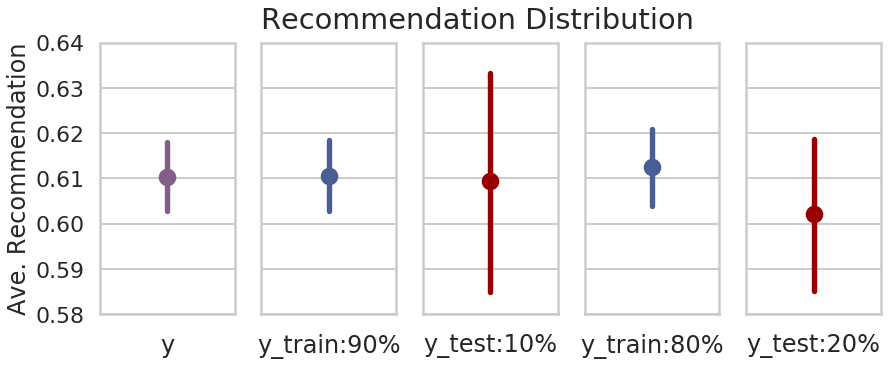

In [32]:
# plot distribution means of training and test sets to compare to unsplit target set

figsize(14, 5)

fig, axes = plt.subplots(1, 5, sharey=True)
fig.subplots_adjust(hspace=0)

# perform a 90/10 split of the target variable into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=27)
clf = MultinomialNB()
clf.fit(X_train, y_train)

# get classification report and confusion matrix
cr_90_10_df = pd.DataFrame(classification_report(y_test, clf.predict(X_test), digits=3, output_dict=True)).transpose()
cm_90_10_df = pd.DataFrame(confusion_matrix(y_test, clf.predict(X_test)))

# transform data to plot
y_df = pd.DataFrame([y, y_train, y_test], index=['y', 'y_train', 'y_test'])
y_df = y_df.transpose()

sns.pointplot(data=y_df, y='y', ax=axes[0], color=mp.colors(1))
axes[0].set(xlabel='y', ylabel='Ave. Recommendation')

sns.pointplot(data=y_df, y='y_train', ax=axes[1])
axes[1].set(xlabel='y_train:90%', ylabel=None)

sns.pointplot(data=y_df, y='y_test', ax=axes[2], color=mp.colors(2))
axes[2].set(xlabel='y_test:10%', ylabel=None)

# perform an 80/20 split of the target variable into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)
clf = MultinomialNB()
clf.fit(X_train, y_train)

# get classification report and confusion matrix
cr_80_20_df = pd.DataFrame(classification_report(y_test, clf.predict(X_test), digits=3, output_dict=True)).transpose()
cm_80_20_df = pd.DataFrame(confusion_matrix(y_test, clf.predict(X_test)))

# transform data to plot
y_df = pd.DataFrame([y, y_train, y_test], index=['y', 'y_train', 'y_test'])
y_df = y_df.transpose()

sns.pointplot(data=y_df, y='y_train', ax=axes[3])
axes[3].set(xlabel='y_train:80%', ylabel=None)

sns.pointplot(data=y_df, y='y_test', ax=axes[4], color=mp.colors(2))
axes[4].set(xlabel='y_test:20%', ylabel=None)

plt.ylim(0.58, 0.64)
plt.yticks(np.divide([y for y in range (58, 65, 1)], 100))

plt.suptitle('Recommendation Distribution')

# display classification report and confusion matrix
df1_styler = cr_90_10_df.style.set_table_attributes("style='display:inline'").set_caption('90:10 Classification Report')
df2_styler = cr_80_20_df.style.set_table_attributes("style='display:inline'").set_caption('80:20 Classification Report')
df3_styler = cm_90_10_df.style.set_table_attributes("style='display:inline'").set_caption('90:10 Confusion Matrix')
df4_styler = cm_80_20_df.style.set_table_attributes("style='display:inline'").set_caption('80:20 Confusion Matrix')

display_html(df1_styler._repr_html_() + df2_styler._repr_html_() + df3_styler._repr_html_() 
             + df4_styler._repr_html_(), raw=True)

The 90/10 split outperforms the traditional 80/20 split in every evaluation metric.

The mean of training set for the 90/10 split is closer to the full set than that of the 80/20 split.<br>
This is not surprising, since they hold nearly the same data points.<br>
What is surprising is that the same holds true for the mean of the test sets.<br>
This may be due to random chance, as the model is the same for both classifications, and only the data is different.

In [33]:
# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=27)

In [34]:
# instantiate the classifier
clf = MultinomialNB()

In [35]:
# train the model
clf.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [36]:
# get classification report and confusion matrix
cr_train_df = pd.DataFrame(classification_report(y_train, clf.predict(X_train), digits=3, output_dict=True)).transpose()
cm_train_df = pd.DataFrame(confusion_matrix(y_train, clf.predict(X_train)))
cr_test_df = pd.DataFrame(classification_report(y_test, clf.predict(X_test), digits=3, output_dict=True)).transpose()
cm_test_df = pd.DataFrame(confusion_matrix(y_test, clf.predict(X_test)))

In [37]:
# get ROC data
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, clf.predict(X_train))
roc_score_train = roc_auc_score(y_train, clf.predict(X_train))
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, clf.predict(X_test))
roc_score_test = roc_auc_score(y_test, clf.predict(X_test))

In [38]:
# get accuracy score on train set
f'Accuracy score on the training data: {clf.score(X_train, y_train)}'

'Accuracy score on the training data: 0.9160228898426324'

In [39]:
# get accuracy score on test set
f'Accuracy score on the testing data: {clf.score(X_test, y_test)}'

'Accuracy score on the testing data: 0.7966537966537967'

The accuracy scores are far apart.<br>
This is an indication that this model is overfit.<br>
This classifier may be better if it were less complex

In [40]:
# display classification report and confusion matrix
df1_styler = cr_train_df.style.set_table_attributes("style='display:inline'").set_caption('Training Classification Report')
df2_styler = cr_test_df.style.set_table_attributes("style='display:inline'").set_caption('Test Classification Report')
df3_styler = cm_train_df.style.set_table_attributes("style='display:inline'").set_caption('Training Confusion Matrix')
df4_styler = cm_test_df.style.set_table_attributes("style='display:inline'").set_caption('Test Confusion Matrix')

display_html(df1_styler._repr_html_() + df2_styler._repr_html_() + df3_styler._repr_html_() 
             + df4_styler._repr_html_(), raw=True)

,precision,recall,f1-score,support
0,0.917498,0.861892,0.888826,5445.000000
1,0.915172,0.950557,0.932529,8535.000000
accuracy,0.916023,0.916023,0.916023,0.916023
macro avg,0.916335,0.906224,0.910677,13980.000000
weighted avg,0.916078,0.916023,0.915507,13980.000000
,precision,recall,f1-score,support
0,0.777143,0.672158,0.720848,607.000000
1,0.806608,0.876452,0.840081,947.000000
accuracy,0.796654,0.796654,0.796654,0.796654
macro avg,0.791876,0.774305,0.780465,1554.000000


The reports show the gap between the performances on the two datasets.<br>
The plot of the ROC curves visualizes this gap.

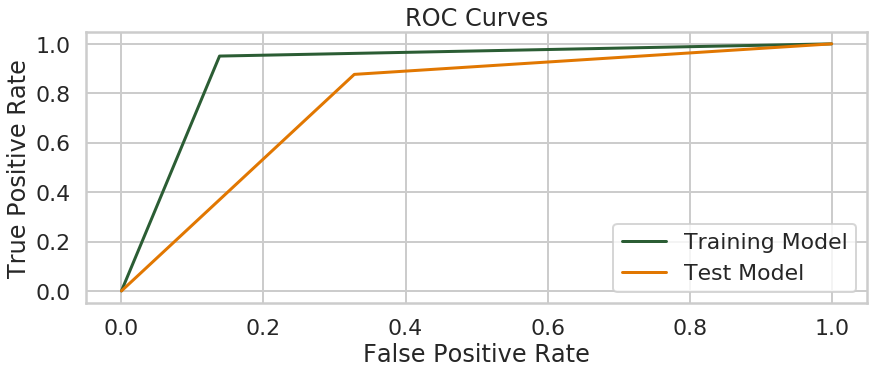

In [41]:
# plot ROC curves

ax = sns.lineplot(fpr_train, tpr_train, color=mp.colors(4), label='Training Model')
ax = sns.lineplot(fpr_test, tpr_test, color=mp.colors(5), label='Test Model')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
plt.title('ROC Curves');

In [42]:
f'Training ROC AUC Score: {roc_score_train}, Test ROC AUC Score: {roc_score_test}'

'Training ROC AUC Score: 0.9062240878185917, Test ROC AUC Score: 0.774305054198727'

There are a few things that could be done to improve the model:
 - Custom tokenization to remove punctuation such as apostrophes in contractions
 - Removal of stop words to reduce noise
 - Stemming or lemmatization to combine similar words based on their common root
 - Use cross-valisation to guard against overfitting
 - Use probabilities for feature selection

### Picking Hyperparameters for Naive Bayes and Text Maintenance

We need to know what value to use for $\alpha$, and we also need to know which words to include in the vocabulary. As mentioned earlier, some words are obvious stopwords. Other words appear so infrequently that they serve as noise, and other words in addition to stopwords appear so frequently that they may also serve as noise.

First, let's find an appropriate value for `min_df` for the `CountVectorizer`. `min_df` can be either an integer or a float/decimal. If it is an integer, `min_df` represents the minimum number of documents a word must appear in for it to be included in the vocabulary. If it is a float, it represents the minimum *percentage* of documents a word must appear in to be included in the vocabulary. From the documentation:

>min_df: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

<div class="span5 alert alert-info">
<h3>Exercise Set III</h3>

<p><b>Exercise:</b> Construct the cumulative distribution of document frequencies (df). The $x$-axis is a document count $x_i$ and the $y$-axis is the percentage of words that appear less than $x_i$ times. For example, at $x=5$, plot a point representing the percentage or number of words that appear in 5 or fewer documents.</p>

<p><b>Exercise:</b> Look for the point at which the curve begins climbing steeply. This may be a good value for `min_df`. If we were interested in also picking `max_df`, we would likely pick the value where the curve starts to plateau. What value did you choose?</p>
</div>

In [43]:
# Your turn.

Let's examine the matrix a little more closely

In [44]:
f'The number of documents in this dataset is {np.size(X, 0):,}'

'The number of documents in this dataset is 15,534'

In [45]:
f'The number of words in this corpus is {np.size(X, 1):,}'

'The number of words in this corpus is 22,400'

There are almost as many documents as there are words.

In [46]:
def get_word_counts(min_df=1, max_df=1.0, stop_words=None):
    """Returns a sorted word and frequency list and a stop word set """
    cv = CountVectorizer(min_df=min_df, max_df=max_df, stop_words=stop_words)
    V = cv.fit_transform(my_df['quote'])
    words_lst = cv.get_feature_names()
    counts_lst = V.toarray().sum(axis=0)
    sort_words = sorted(dict(zip(words_lst, counts_lst)).items(), key=lambda x: x[1], reverse=True)
    return sort_words, cv.stop_words_

In [47]:
# create DataFrame of words in corpus and the number of their document appearances
words_df = pd.DataFrame(get_word_counts()[0], columns=['word', 'freq'])
words_df.head(3)

,word,freq
0,the,16782
1,and,9887
2,of,9761


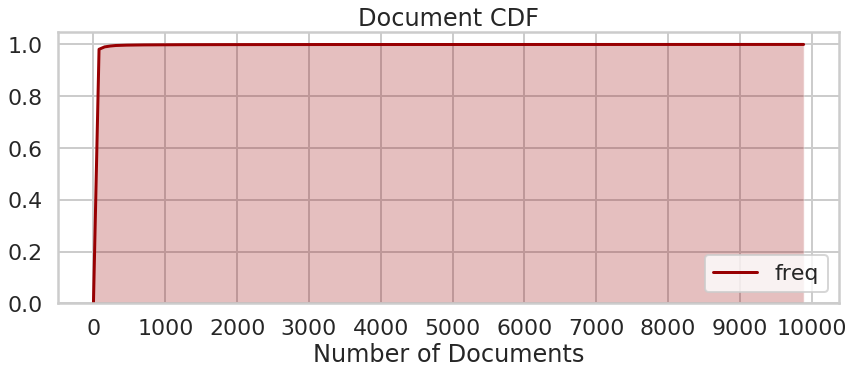

In [48]:
# plot CDF of documents for number of word appearances

sns.kdeplot(words_df['freq'].sort_values(), cumulative=True, clip=(0, 10000), shade=True, color=mp.colors(2))

plt.xticks([x for x in range (0, 10001, 1000)]);

plt.xlabel('Number of Documents')
plt.title('Document CDF');

Let's focus on different parts of the plot.

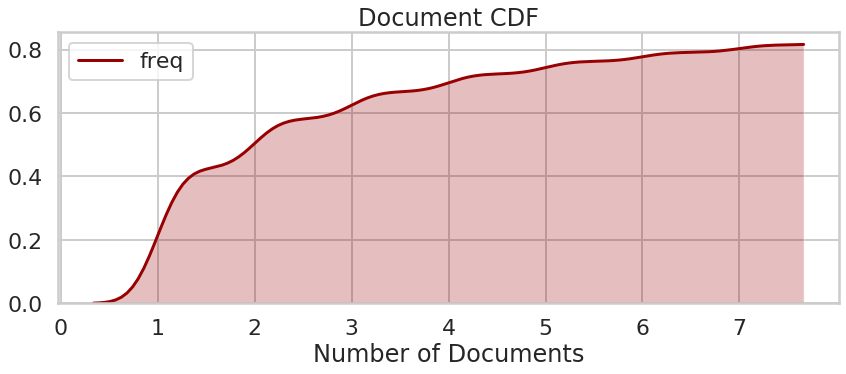

In [49]:
# plot CDF of documents for lowest number of word appearances

sns.kdeplot(words_df['freq'].sort_values(), cumulative=True, clip=(0, 8), shade=True, color=mp.colors(2))

plt.xticks([x for x in range (0, 8, 1)])

plt.xlabel('Number of Documents')
plt.title('Document CDF');

In [50]:
# get number of words appearing in only one document
(words_df['freq'].sort_values() == 1).sum()

9547

The curve begins to climb steeply right away.<br>
I will try a value of min_df=2.

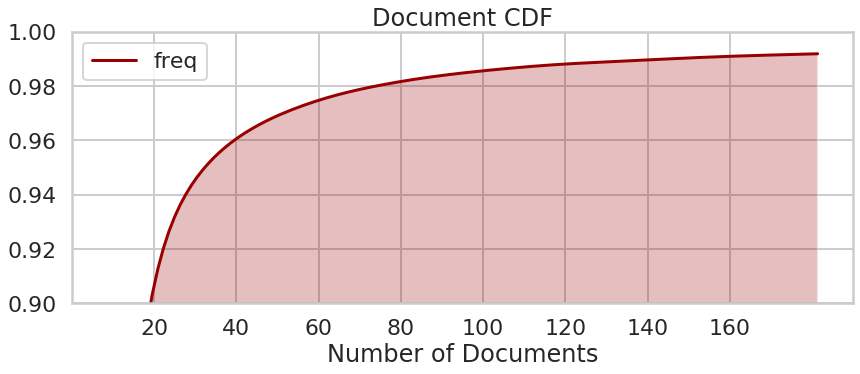

In [51]:
# plot CDF of documents where additon of word appearances starts to decline

sns.kdeplot(words_df['freq'].sort_values(), cumulative=True, clip=(30, 160), shade=True, color=mp.colors(2))

plt.ylim(0.9, 1)

plt.xticks([x for x in range (20, 161, 20)])

plt.xlabel('Number of Documents')
plt.title('Document CDF');

This curve doesn't quite plateau, but it does seem to slow it's bending around 100 documents.<br>
A grid search should be used to determine the cutoff.<br>
I will try a value of max_df=100.

Now, I want to look at the words that I will be dropping.

In [52]:
# get top words while not removing stop words
sort_words, stop_words = get_word_counts()
print(sort_words[:100])
f'Stop Words: {stop_words}'

[('the', 16782), ('and', 9887), ('of', 9761), ('to', 6228), ('is', 5969), ('it', 5325), ('in', 4245), ('that', 3676), ('as', 2854), ('with', 2570), ('but', 2406), ('this', 2332), ('film', 2264), ('movie', 2197), ('for', 2144), ('its', 1902), ('an', 1834), ('you', 1406), ('be', 1404), ('on', 1389), ('by', 1330), ('has', 1298), ('one', 1294), ('not', 1236), ('are', 1155), ('more', 1119), ('his', 1081), ('all', 1068), ('than', 1037), ('at', 1023), ('about', 1017), ('from', 990), ('have', 885), ('so', 873), ('like', 864), ('most', 821), ('there', 788), ('what', 743), ('if', 711), ('he', 703), ('or', 701), ('good', 689), ('can', 686), ('who', 686), ('up', 663), ('story', 657), ('into', 643), ('much', 613), ('out', 598), ('comedy', 588), ('even', 572), ('time', 545), ('too', 544), ('best', 538), ('director', 529), ('just', 507), ('no', 504), ('which', 496), ('well', 477), ('they', 472), ('funny', 468), ('some', 460), ('movies', 443), ('when', 438), ('make', 437), ('their', 437), ('will', 433

'Stop Words: set()'

These are the top 30 words. Except for film and movie, they all seem very common to daily use.

In [53]:
# get top words appearing in 2 documents or more and count of stop words omitted
sort_words, stop_words = get_word_counts(min_df=2)
print(sort_words[:15])
f'Number of Stop Words: {len(stop_words)}'

[('the', 16782), ('and', 9887), ('of', 9761), ('to', 6228), ('is', 5969), ('it', 5325), ('in', 4245), ('that', 3676), ('as', 2854), ('with', 2570), ('but', 2406), ('this', 2332), ('film', 2264), ('movie', 2197), ('for', 2144)]


'Number of Stop Words: 9582'

This is a lot of words, but they only appear in one document each.

In [54]:
# get top words appearing in 100 documents or less and stop words omitted
sort_words, stop_words = get_word_counts(max_df=100)
print(sort_words[:15])
f'Stop Words: {stop_words}'

[('ll', 103), ('my', 103), ('especially', 101), ('level', 101), ('sweet', 101), ('energy', 100), ('jokes', 100), ('kids', 100), ('scene', 100), ('wit', 100), ('actor', 99), ('dark', 99), ('version', 99), ('days', 98), ('light', 98)]


"Stop Words: {'which', 'motion', 'funny', 'very', 'become', 'you', 'look', 'he', 'end', 'an', 'part', 'three', 'into', 'while', 'by', 'always', 'clever', 'out', 'humor', 'real', 'feature', 'one', 'him', 'give', 'bad', 'other', 'action', 'least', 'half', 'director', 'such', 'acting', 'work', 'see', 'on', 'quite', 'from', 'series', 'probably', 'adventure', 'can', 'takes', 'still', 'me', 'find', 'power', 'black', 'watch', 'just', 'intelligent', 'that', 'pretty', 'every', 'family', 'only', 'been', 'film', 'anyone', 'full', 'character', 'up', 'first', 'simply', 'isn', 'entertainment', 'turns', 'laughs', 'big', 'minutes', 'do', 'come', 'small', 'art', 'comes', 'in', 'our', 'this', 'worth', 'had', 'also', 'some', 'about', 'don', 'once', 'may', 'better', 'set', 'enjoyable', 'day', 'could', 'as', 'were', 'through', 'cast', 'long', 'drama', 'story', 'around', 'after', 'itself', 'not', 'say', 'many', 'before', 'so', 'people', 'bit', 'actors', 'role', 'disney', 'sense', 'being', 'comedy', 'play', 

In a general context these word may be overused, but for classifying movie recommendations some of them hold more moviegoer specific value.<br>
I would want to keep these words:
 - good, intelligent, funny, disney, love, bad, special, entertaining, emotional, great, hitchcock, laughs, interesting, cleaver, enjoyable

It is odd that the top 5 words left in the corpus each appear in over 100 documents, as the function is supposed to drop them..

After observing model accuracy through a wide range of max_df, I found the best number for my data was around 800 document appearances.<br>
Unfortuately, when using any cutoff value at all for max_df, the performance scores drop.<br>
I will not set this parameter for my model.

The parameter $\alpha$ is chosen to be a small value that simply avoids having zeros in the probability computations. This value can sometimes be chosen arbitrarily with domain expertise, but we will use K-fold cross validation. In K-fold cross-validation, we divide the data into $K$ non-overlapping parts. We train on $K-1$ of the folds and test on the remaining fold. We then iterate, so that each fold serves as the test fold exactly once. The function `cv_score` performs the K-fold cross-validation algorithm for us, but we need to pass a function that measures the performance of the algorithm on each fold. 

In [55]:
from sklearn.model_selection import KFold
def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    for train, test in KFold(nfold).split(X): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit the classifier, passed is as clf.
        result += scorefunc(clf, X[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

I will make my own function with customized parameters.

In [56]:
def my_cv_score(clf, X, y, scorefunc):
    """Returns average of 10 fold cross validation"""
    result = 0
    # do more folds
    nfold = 10
    # shuffle data and set random number generator
    for train, test in KFold(nfold, shuffle=True, random_state=27).split(X):
        clf.fit(X[train], y[train])
        result += scorefunc(clf, X[test], y[test])
    return result / nfold

We use the log-likelihood as the score here in `scorefunc`. The higher the log-likelihood, the better. Indeed, what we do in `cv_score` above is to implement the cross-validation part of `GridSearchCV`.

The custom scoring function `scorefunc` allows us to use different metrics depending on the decision risk we care about (precision, accuracy, profit etc.) directly on the validation set. You will often find people using `roc_auc`, precision, recall, or `F1-score` as the scoring function.

In [57]:
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

We'll cross-validate over the regularization parameter $\alpha$.

Let's set up the train and test masks first, and then we can run the cross-validation procedure.

In [58]:
from sklearn.model_selection import train_test_split
_, itest = train_test_split(range(critics.shape[0]), train_size=0.7)
mask = np.zeros(critics.shape[0], dtype=np.bool)
mask[itest] = True

In [59]:
# observe proportions of split
critics.shape[0], len(_), len(itest)

(15561, 10892, 4669)

This mask is the length of the TEST data.<br>
In the preloaded code below, it is used to get the TRAINING sets.<br>
I will continue using my own code, as this is not correct.

<div class="span5 alert alert-info">
<h3>Exercise Set IV</h3>

<p><b>Exercise:</b> What does using the function `log_likelihood` as the score mean? What are we trying to optimize for?</p>

<p><b>Exercise:</b> Without writing any code, what do you think would happen if you choose a value of $\alpha$ that is too high?</p>

<p><b>Exercise:</b> Using the skeleton code below, find the best values of the parameter `alpha`, and use the value of `min_df` you chose in the previous exercise set. Use the `cv_score` function above with the `log_likelihood` function for scoring.</p>
</div>

The log-likelihood function gives the probabilities of observing our data given a distribution of the regulatization parameter ($\alpha$).<br>
We are using the maximum likelihood estimate (MLE) to find the best $\alpha$ such that our observed data is most probable through maximizing the log-likelihood.

To make predictions using Naive Bayes, we need to find out which class has the larger probability.<br>
Here we are calculating joint probabilities, which involves multiplying probabilities together.<br>
This may result in very small numbers.<br>
By taking the log of the probabilities we can avoid running into difficulties with the precision our floating point values.

Higher values of $\alpha$ will assign higher probabilities to words that our model has not seen.<br>
Chooing an $\alpha$ that is too high will cause our classifier to underfit, because as $\alpha$ --> ${\infty}$, our variance --> 0, and the bias gets very high.<br>
In other words, with very high $\alpha$ the classifier does not change, regardless of the data.

In [60]:
from sklearn.naive_bayes import MultinomialNB

#the grid of parameters to search over
alphas = [.1, 1, 5, 10, 50]
best_min_df = 2 # YOUR TURN: put your value of min_df here.

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
maxscore=-np.inf
for alpha in alphas:
    vectorizer = CountVectorizer(min_df=best_min_df)       
    Xthis, ythis = make_xy(critics, vectorizer)
    Xtrainthis = Xthis[mask]
    ytrainthis = ythis[mask]
    # your turn  

In [61]:
# observe proportions of split
critics.shape[0], Xtrainthis.shape[0], len(ytrainthis)

(15561, 4669, 4669)

As mentioned, the skeleton code above incorrectly names the test set as the training set, as it is 30% of the observations.

In [62]:
# reset mask to the size of my data and test split size

# create list (itest) of random integers the length of the y_test portion of the split
_, itest = train_test_split(range(my_df.shape[0]), train_size=0.9, random_state=27)
# create array of False values whose length is equal to the full number of observations (documents)
mask = np.zeros(my_df.shape[0], dtype=np.bool)
# change False values to True at the indices that match the values found in itest list
mask[itest] = True

In [63]:
# observe proportions of split
my_df.shape[0], len(_), len(itest)

(15534, 13980, 1554)

These are the correct proportions for the split I want.

In [64]:
def get_best_alpha():
    """Returns log likelihood scores and best score for a range of regularization parameters"""
    # initialize return values
    best_score = -np.inf
    best_alpha = None
    results = {}
    for alpha in alphas:
        # prepare data with chosen min_df argument
        X, y, _ = my_make_xy(my_df, min_df=2)
        # extract test sets with mask array
        X_test = X[mask]
        y_test = y[mask]
        # instanciate classifier for each value of alpha
        clf = MultinomialNB(alpha)
        # score each classifier
        score = my_cv_score(clf, X_test, y_test, log_likelihood)
        # get each score
        results[alpha] = score
        # set best alpha and its score
        if score > best_score:
            best_score = score
            best_alpha = alpha
    return results, best_alpha, best_score        

In [65]:
results, best_alpha, best_score = get_best_alpha()
f'Best alpha: {best_alpha}  score: {best_score}', results

('Best alpha: 1  score: -140.8675904277695',
 {0.1: -182.95210897441362,
  1: -140.8675904277695,
  5: -208.76570099912814,
  10: -217.91574475419776,
  50: -190.6863914803402})

In [66]:
print("alpha: {}".format(best_alpha))

alpha: 1


<div class="span5 alert alert-info">
<h3>Exercise Set V: Working with the Best Parameters</h3>

<p><b>Exercise:</b> Using the best value of  `alpha` you just found, calculate the accuracy on the training and test sets. Is this classifier better? Why (not)?</p>

</div>

In [67]:
# reset mask back to preloaded data to ensure notebook cells run
_, itest = train_test_split(range(critics.shape[0]), train_size=0.7)
mask = np.zeros(critics.shape[0], dtype=np.bool)
mask[itest] = True

This is the preloaded code below that I will not use.

In [68]:
vectorizer = CountVectorizer(min_df=best_min_df)
X, y = make_xy(critics, vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.934033
Accuracy on test data:     0.749449


In [69]:
# observe proportions of split
critics.shape[0], xtrain.shape[0], xtest.shape[0]

(15561, 4669, 10892)

As noted, there is a logical error in the preloaded code pertaining to the implementation of the mask.<br>
If used, this will give incorrect results.

In [70]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(ytest, clf.predict(xtest)))

[[2445 1791]
 [ 938 5718]]


Now, I will use my data and functions.

In [71]:
#your turn. Print the accuracy on the test and training dataset

In [72]:
# reset mask back to my data
_, itest = train_test_split(range(my_df.shape[0]), train_size=0.9, random_state=27)
mask = np.zeros(my_df.shape[0], dtype=np.bool)
mask[itest] = True

In [73]:
# change a couple of items to fit my data and custom function
X, y, _ = my_make_xy(my_df, min_df=2)
# code the mask assignments correctly to gain 5% accuracy
xtrain = X[~mask]
ytrain = y[~mask]
xtest= X [mask]
ytest= y [mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

# get accuracy on test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

# get classification report and confusion matrix
cr_train_df_new = pd.DataFrame(classification_report(ytrain, clf.predict(xtrain), digits=3, output_dict=True)).transpose()
cm_train_df_new = pd.DataFrame(confusion_matrix(ytrain, clf.predict(xtrain)))
cr_test_df_new = pd.DataFrame(classification_report(ytest, clf.predict(xtest), digits=3, output_dict=True)).transpose()
cm_test_df_new = pd.DataFrame(confusion_matrix(ytest, clf.predict(xtest)))

# get ROC data
fpr_train_new, tpr_train_new, thresholds_new = roc_curve(ytrain, clf.predict(xtrain))
roc_score_train_new = roc_auc_score(ytrain, clf.predict(xtrain))
fpr_test_new, tpr_test_new, thresholds_new = roc_curve(ytest, clf.predict(xtest))
roc_score_test_new = roc_auc_score(ytest, clf.predict(xtest))

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.893419
Accuracy on test data:     0.799871


In [74]:
print(confusion_matrix(ytest, clf.predict(xtest)))

[[431 176]
 [135 812]]


In [75]:
# display classification report and confusion matrix for training model
df1_styler = cr_train_df.style.set_table_attributes("style='display:inline'").set_caption('Old Training Classification Report')
df2_styler = cr_train_df_new.style.set_table_attributes("style='display:inline'").set_caption('New Training Classification Report')
df3_styler = cm_train_df.style.set_table_attributes("style='display:inline'").set_caption('Old Training Confusion Matrix')
df4_styler = cm_train_df_new.style.set_table_attributes("style='display:inline'").set_caption('New Training Confusion Matrix')

display_html(df1_styler._repr_html_() + df2_styler._repr_html_() + df3_styler._repr_html_() 
             + df4_styler._repr_html_(), raw=True)

,precision,recall,f1-score,support
0,0.917498,0.861892,0.888826,5445.000000
1,0.915172,0.950557,0.932529,8535.000000
accuracy,0.916023,0.916023,0.916023,0.916023
macro avg,0.916335,0.906224,0.910677,13980.000000
weighted avg,0.916078,0.916023,0.915507,13980.000000
,precision,recall,f1-score,support
0,0.867087,0.857851,0.862445,5445.000000
1,0.909927,0.916110,0.913008,8535.000000
accuracy,0.893419,0.893419,0.893419,0.893419
macro avg,0.888507,0.886981,0.887726,13980.000000


The new model is overfitting less on the training set.

In [76]:
# display classification report and confusion matrix for test model
df1_styler = cr_test_df.style.set_table_attributes("style='display:inline'").set_caption('Old Test Classification Report')
df2_styler = cr_test_df_new.style.set_table_attributes("style='display:inline'").set_caption('New Test Classification Report')
df3_styler = cm_test_df.style.set_table_attributes("style='display:inline'").set_caption('Old Test Confusion Matrix')
df4_styler = cm_test_df_new.style.set_table_attributes("style='display:inline'").set_caption('New Test Confusion Matrix')

display_html(df1_styler._repr_html_() + df2_styler._repr_html_() + df3_styler._repr_html_() 
             + df4_styler._repr_html_(), raw=True)

,precision,recall,f1-score,support
0,0.777143,0.672158,0.720848,607.000000
1,0.806608,0.876452,0.840081,947.000000
accuracy,0.796654,0.796654,0.796654,0.796654
macro avg,0.791876,0.774305,0.780465,1554.000000
weighted avg,0.795099,0.796654,0.793508,1554.000000
,precision,recall,f1-score,support
0,0.761484,0.710049,0.734868,607.000000
1,0.821862,0.857445,0.839276,947.000000
accuracy,0.799871,0.799871,0.799871,0.799871
macro avg,0.791673,0.783747,0.787072,1554.000000


The new model correctly classified a larger percentage of actual rotten movies than the default model did.<br>
Although, it did not do the same when classifying actual fresh movies.<br>
Also, the new model had a larger percentage of the movies it classified as fresh that were actually freah movies than the default model did.<br>
The opposite was true about the movies that it classified as rotten.

Looking at the F1 scores, the both models are better classifiers of fresh movies than they are of rotten movies.

In [77]:
old_train_accuracy = cr_train_df['support']['accuracy']
new_train_accuracy = cr_train_df_new['support']['accuracy']
f'Old Model Training Accuracy: {old_train_accuracy}, New Model Training Accuracy: {new_train_accuracy}'

'Old Model Training Accuracy: 0.9160228898426324, New Model Training Accuracy: 0.8934191702432046'

In [78]:
old_test_accuracy = cr_test_df['support']['accuracy']
new_test_accuracy = cr_test_df_new['support']['accuracy']
f'Old Model Testing Accuracy: {old_test_accuracy}, New Model Testing Accuracy: {new_test_accuracy}'

'Old Model Testing Accuracy: 0.7966537966537967, New Model Testing Accuracy: 0.7998712998712999'

In [79]:
# check if difference between scores of training and test predictions decreased
(new_train_accuracy - new_test_accuracy) < (old_train_accuracy - old_test_accuracy)

True

The gap in accuracy between training and test predictions has narrowed.

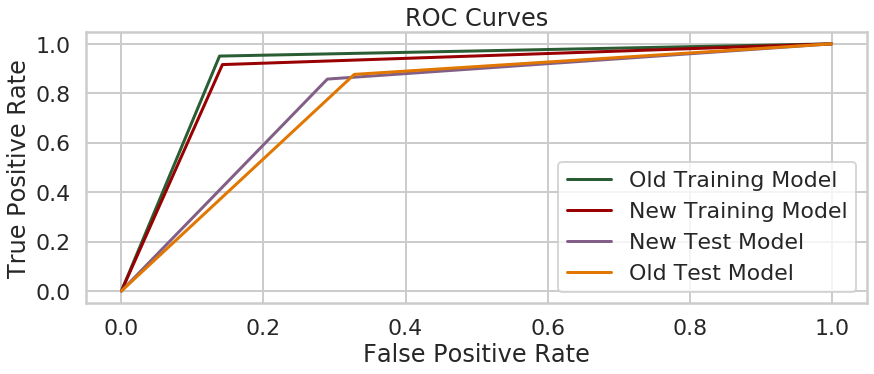

In [80]:
# plot ROC curves

ax = sns.lineplot(fpr_train, tpr_train, color=mp.colors(4), label='Old Training Model')
ax = sns.lineplot(fpr_train_new, tpr_train_new, color=mp.colors(2), label='New Training Model')
ax = sns.lineplot(fpr_test_new, tpr_test_new, color=mp.colors(1), label='New Test Model')
ax = sns.lineplot(fpr_test, tpr_test, color=mp.colors(5), label='Old Test Model')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
plt.title('ROC Curves');

In [81]:
f'Old Training Model ROC AUC Score: {roc_score_train}, New Training Model ROC AUC Score: {roc_score_train_new}'

'Old Training Model ROC AUC Score: 0.9062240878185917, New Training Model ROC AUC Score: 0.8869806872043651'

In [82]:
f'Old Test Model ROC AUC Score: {roc_score_test}, New Test Model ROC AUC Score: {roc_score_test_new}'

'Old Test Model ROC AUC Score: 0.774305054198727, New Test Model ROC AUC Score: 0.7837469925838816'

As can be clearly seen in the ROC plot, the gap has narrowed between the performances on the training and test sets.<br>
The new model is overfitting less on the training data and is a better predictor than the default model.

## Interpretation

### What are the strongly predictive features?

We use a neat trick to identify strongly predictive features (i.e. words). 

* first, create a data set such that each row has exactly one feature. This is represented by the identity matrix.
* use the trained classifier to make predictions on this matrix
* sort the rows by predicted probabilities, and pick the top and bottom $K$ rows

In [83]:
words = np.array(vectorizer.get_feature_names())

x = np.eye(xtest.shape[1])
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t     P(fresh | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad words\t     P(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Good words	     P(fresh | word)
          delicately 0.98
           absorbing 0.97
            captures 0.97
              torrid 0.97
        intertwining 0.96
                 rot 0.96
          mysterious 0.96
                seat 0.96
           childhood 0.96
        experiencing 0.95
Bad words	     P(fresh | word)
           trademark 0.08
       unpretentious 0.07
            unflashy 0.07
                wish 0.06
            ignorant 0.06
               dirty 0.06
               bland 0.05
          poetically 0.04
             unhappy 0.04
                laff 0.03


<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Why does this method work? What does the probability for each row in the identity matrix represent</p>

</div>

The classifier is predicting the target class of a word by treating each word as the only one in a test document.<br>
This results in assigning a class to each word based on the probability that it is associated with the positive target class. 

The above exercise is an example of *feature selection*. There are many other feature selection methods. A list of feature selection methods available in `sklearn` is [here](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection). The most common feature selection technique for text mining is the chi-squared $\left( \chi^2 \right)$ [method](http://nlp.stanford.edu/IR-book/html/htmledition/feature-selectionchi2-feature-selection-1.html).

### Prediction Errors

We can see mis-predictions as well.

I am leaving this preloaded code below, but need to add some cells to ensure the notebook runs through.

In [84]:
# reset mask back to preloaded data
_, itest = train_test_split(range(critics.shape[0]), train_size=0.7)
mask = np.zeros(critics.shape[0], dtype=np.bool)
mask[itest] = True

In [85]:
# retrain model on preloaded data
vectorizer = CountVectorizer(min_df=best_min_df)
X, y = make_xy(critics, vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

In [86]:
x, y = make_xy(critics, vectorizer)

prob = clf.predict_proba(x)[:, 0]
predict = clf.predict(x)

bad_rotten = np.argsort(prob[y == 0])[:5]
bad_fresh = np.argsort(prob[y == 1])[-5:]

print("Mis-predicted Rotten quotes")
print('---------------------------')
for row in bad_rotten:
    print(critics[y == 0].quote.iloc[row])
    print("")

print("Mis-predicted Fresh quotes")
print('--------------------------')
for row in bad_fresh:
    print(critics[y == 1].quote.iloc[row])
    print("")

Mis-predicted Rotten quotes
---------------------------
What if this lesser-known chapter of German resistance had been more deeply captured? What if the moral conflicts running through this movie about love of country and revolt said more about Germany, war and, yes, genocide?

An ambitious, serious but not particularly stimulating musical feature that unconvincingly attempts to graft warm and cuddly family-film motifs onto turbulent aspects of modern history and mythology.

Highly stylized fashion-wise but awkwardly unfocused in its plotlines, it aims for the western iconography of Sam Peckinpah and Sergio Leone but never gets past its own directorial hurdles.

Benefits from a lively lead performance by the miscast Denzel Washington but doesn't come within light years of the book, one of the greatest American autobiographies.

Night Watch was one of the most popular movies ever released in Russia. That just proves there's no accounting for taste, in film or in human sacrifice.

Mis-p

Now, I will use my data and functions to see what output they produce.

In [87]:
# reset mask back to my data
_, itest = train_test_split(range(my_df.shape[0]), train_size=0.9, random_state=27)
mask = np.zeros(my_df.shape[0], dtype=np.bool)
mask[itest] = True

In [88]:
# retrain model on my data
X, y, _ = my_make_xy(my_df, min_df=2)
xtrain = X[~mask]
ytrain = y[~mask]
xtest = X[mask]
ytest = y[mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

In [89]:
# get wrong predictions from my data
x, y, _ = my_make_xy(my_df, min_df=2)

prob = clf.predict_proba(x)[:, 0]
predict = clf.predict(x)

bad_rotten = np.argsort(prob[y == 0])[:5]
bad_fresh = np.argsort(prob[y == 1])[-5:]

print("Mis-predicted Rotten quotes")
print('---------------------------')
for row in bad_rotten:
    print(my_df[y == 0]['quote'].iloc[row])
    print("")

print("Mis-predicted Fresh quotes")
print('--------------------------')
for row in bad_fresh:
    print(my_df[y == 1]['quote'].iloc[row])
    print("")

Mis-predicted Rotten quotes
---------------------------
This pacifist spirit of brotherhood echoes the heroics in Princess Mononoke and other anime titles, but the artistic gap between the Miyazaki masterpiece and this project is huge.

Malkovich does such wonderfully unexpected things, especially with his line readings, that he leaves us dumbfounded. No other performer is more effortlessly unnerving than this perversely gifted actor.

If it's to be experienced at all, Return to Paradise is best seen as a lively piece of pulp, not a profound exploration of the vagaries of the human soul.

All of this would work better if Robinson built up the reality of the town more, made the citizens a more palpable presence, as Frank Capra did in Hollywood's greatest fable-fantasy, It's a Wonderful Life.

Handsome, but curiously cold, considering the emotional heat of Anglo-Irish matters. Fortunately, Liam Neeson commands almost every frame.

Mis-predicted Fresh quotes
--------------------------
The

In [90]:
# observe missed rotten quote
my_df[my_df['quote'] == 
      'Malkovich does such wonderfully unexpected things, especially with his line readings, that he leaves us dumbfounded. No other performer is more effortlessly unnerving than this perversely gifted actor.']

,index,quote,fresh
2634,4809,Malkovich does such wonderfully unexpected thi...,rotten


I am not surprised that this one was missed.<br>
There is nothing in this quote that would suggest a negative recommendation.

In [91]:
# observe missed fresh quote
my_df[my_df['quote'] == 
      "Some of the gags don't work, but fewer than in any previous Brooks film that I've seen, and when the jokes are meant to be bad, they are riotously poor. What more can one ask of Mel Brooks?"]

,index,quote,fresh
6166,10633,"Some of the gags don't work, but fewer than in...",fresh


This is an example of a positive recommendation based on a comparison to other movies made by the same person, instead of to movies in general.<br>
It is not surprising that most of the missed positive recommendations were on reviews with this subjective view.

<div class="span5 alert alert-info">
<h3>Exercise Set VII: Predicting the Freshness for a New Review</h3>
<br/>
<div>
<b>Exercise:</b>
<ul>
<li> Using your best trained classifier, predict the freshness of the following sentence: *'This movie is not remarkable, touching, or superb in any way'*
<li> Is the result what you'd expect? Why (not)?
</ul>
</div>
</div>

In [92]:
#your turn

In [93]:
# retrain model on my data
X, y, vectorizer = my_make_xy(my_df, min_df=2)
xtrain = X[~mask]
ytrain = y[~mask]
xtest = X[mask]
ytest = y[mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

In [94]:
# set new test data
holdout_doc = ['This movie is not remarkable, touching, or superb in any way']

In [95]:
# convert new data to sparze matrix
holdout_matrix = vectorizer.transform(holdout_doc)

In [96]:
# predict class
f'The predicted class is fresh.'if clf.predict(holdout_matrix)[0] == 1 else f'The predicted class is rotten.'

'The predicted class is fresh.'

This is what I expected.<br>
The classifier is not trained to consider word contexts such as sentence negations.

### Aside: TF-IDF Weighting for Term Importance

TF-IDF stands for 

`Term-Frequency X Inverse Document Frequency`.

In the standard `CountVectorizer` model above, we used just the term frequency in a document of words in our vocabulary. In TF-IDF, we weight this term frequency by the inverse of its popularity in all documents. For example, if the word "movie" showed up in all the documents, it would not have much predictive value. It could actually be considered a stopword. By weighing its counts by 1 divided by its overall frequency, we downweight it. We can then use this TF-IDF weighted features as inputs to any classifier. **TF-IDF is essentially a measure of term importance, and of how discriminative a word is in a corpus.** There are a variety of nuances involved in computing TF-IDF, mainly involving where to add the smoothing term to avoid division by 0, or log of 0 errors. The formula for TF-IDF in `scikit-learn` differs from that of most textbooks: 

$$\mbox{TF-IDF}(t, d) = \mbox{TF}(t, d)\times \mbox{IDF}(t) = n_{td} \log{\left( \frac{\vert D \vert}{\vert d : t \in d \vert} + 1 \right)}$$

where $n_{td}$ is the number of times term $t$ occurs in document $d$, $\vert D \vert$ is the number of documents, and $\vert d : t \in d \vert$ is the number of documents that contain $t$

In [97]:
# http://scikit-learn.org/dev/modules/feature_extraction.html#text-feature-extraction
# http://scikit-learn.org/dev/modules/classes.html#text-feature-extraction-ref
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvectorizer = TfidfVectorizer(min_df=1, stop_words='english')
Xtfidf=tfidfvectorizer.fit_transform(critics.quote)

<div class="span5 alert alert-info">
<h3>Exercise Set VIII: Enrichment <b>(Optional)</b></h3>

<p>
There are several additional things we could try. Try some of these as exercises:
<ol>
<li> Build a Naive Bayes model where the features are n-grams instead of words. N-grams are phrases containing n words next to each other: a bigram contains 2 words, a trigram contains 3 words, and 6-gram contains 6 words. This is useful because "not good" and "so good" mean very different things. On the other hand, as n increases, the model does not scale well since the feature set becomes more sparse.
<li> Try a model besides Naive Bayes, one that would allow for interactions between words -- for example, a Random Forest classifier.
<li> Try adding supplemental features -- information about genre, director, cast, etc.
<li> Use word2vec or [Latent Dirichlet Allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) to group words into topics and use those topics for prediction.
<li> Use TF-IDF weighting instead of word counts.
</ol>
</p>

<b>Exercise:</b> Try at least one of these ideas to improve the model (or any other ideas of your own). Implement here and report on the result. 
</div>

In [98]:
# Your turn